In [1]:
import numpy as np
import pandas as pd
import holmc as hc
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split

In [2]:
mushroom = fetch_ucirepo(id=73)
X_raw = mushroom.data.features
y_raw = mushroom.data.targets

# Step 1: Convert to pandas DataFrame / Series
X_df = pd.DataFrame(X_raw)
y_series = pd.Series(y_raw.values.ravel(), name="target")

# Step 2: Split the raw data (not encoded yet!)
X_train_df, X_test_df, y_train_series, y_test_series = train_test_split(
    X_df, y_series, test_size=0.30, random_state=42, stratify=y_series
)

# Step 3: Encode labels (target values)
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train_series)
y_test = label_encoder.transform(y_test_series) 

# Step 4: One-hot encode features
encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
X_train_encoded = encoder.fit_transform(X_train_df)
X_test_encoded = encoder.transform(X_test_df) 

# Step 5: Add intercept term (column of 1s)
X_train = np.hstack((np.ones((X_train_encoded.shape[0], 1)), X_train_encoded))
X_test = np.hstack((np.ones((X_test_encoded.shape[0], 1)), X_test_encoded))

In [3]:
seed = 101
np.random.seed(seed)
N = 150  # number of samples
lamb = 25

In [4]:
etas = [0.00001, 0.0001, 0.0004, 0.0008, 0.003, 0.006, 0.009, 0.012]
gammas = [1, 5, 10, 20, 40, 80]
xis = [1, 5, 10, 20, 40, 80]

In [5]:
metric = hc.AccuracyMeasure(X=X_test, y=y_test)
accuracies = {}
StDev = {}
search_o4 = hc.GridSearchClassification(
    gammas=gammas, etas=etas, N=N, seed=seed,show_progress=True
)
o4paramspace=search_o4.run(X=X_train, y=y_train, lamb=lamb)
o4best_gamma = o4paramspace.iloc[0,0]
o4best_eta = o4paramspace.iloc[0,1]
o4p = hc.O4Params(gamma=o4best_gamma, eta=o4best_eta)
sampler4 = hc.HoLMCSamplerO4Classification(
    params=o4p, N=N, seed=seed, show_progress=True
)
sample4 = sampler4.sample(X=X_train, y=y_train, lamb=lamb)
accuracies['Order 4'] = metric.compute_accuracy(sample4)
StDev['Order 4'] = np.std(accuracies['Order 4'], axis=0)

100%|██████████| 150/150 [00:00<00:00, 253.59it/s]


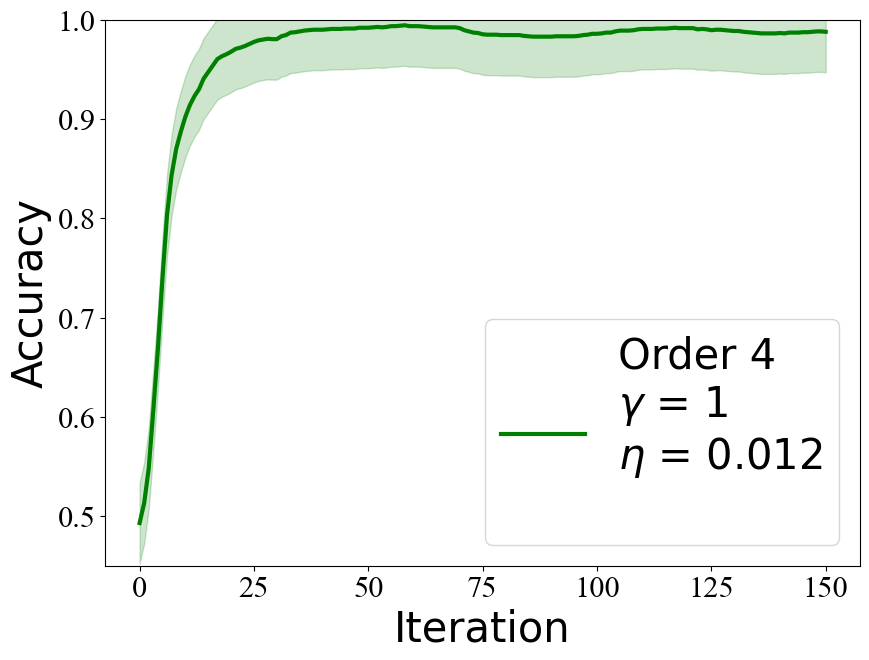

In [6]:
# Plotting
figure, ax = plt.subplots(figsize=(8.8, 6.6))
index = list(range(N+1))

label_str4 = (
    "Order 4\n"
    f"$\\gamma$ = {o4best_gamma}\n"
    f"$\\eta$ = {o4best_eta}\n"
)

plt.plot(index, accuracies['Order 4'], label=label_str4, color='green', linewidth=3)
plt.fill_between(index, 
                 accuracies['Order 4'] - 0.5 * StDev['Order 4'], 
                 accuracies['Order 4'] +0.5 * StDev['Order 4'], 
                 color='green', alpha=0.2)
plt.xlabel("Iteration", fontsize=30)
plt.ylabel("Accuracy", fontsize=30)
plt.legend(fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=22) 
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontname('Times New Roman')
plt.tight_layout()
plt.ylim(0.45, 1)
plt.savefig('../images/4class.png')
plt.show()

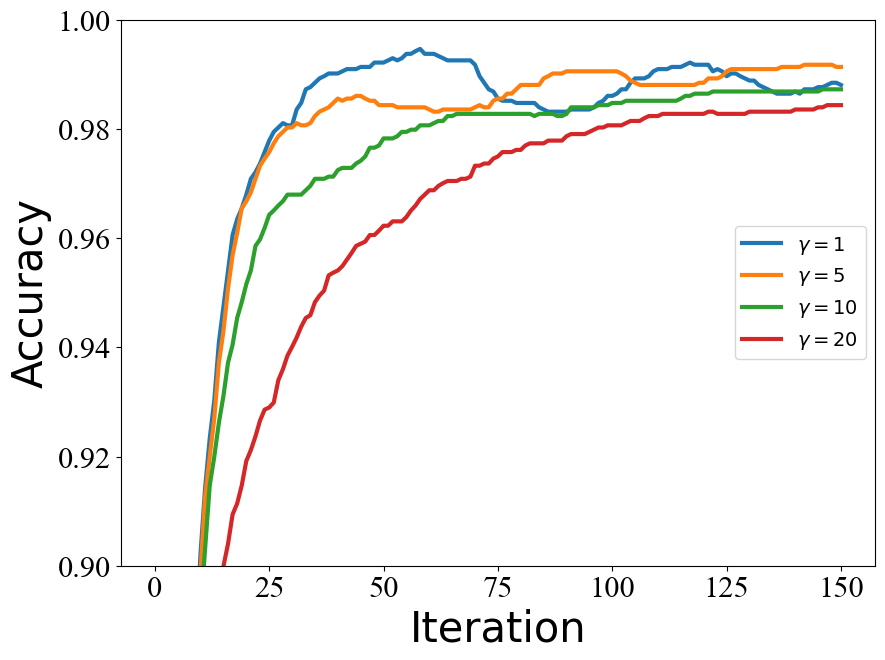

In [7]:
gamma_vals = [1, 5, 10, 20]
eta = o4best_eta

AccForGammaVar_o4 = {}
for gamma in gamma_vals:
    o4p = hc.O4Params(gamma=gamma, eta=eta)
    sampler = hc.HoLMCSamplerO4Classification(
        params=o4p, N=N, seed=seed, show_progress=False
    )
    sample = sampler.sample(X=X_train, y=y_train, lamb=lamb)
    AccForGammaVar_o4[gamma] = metric.compute_accuracy(sample)
AccForGammaVar_o4df = pd.DataFrame(AccForGammaVar_o4)
figure, ax = plt.subplots(figsize=(8.8, 6.6))
for col, gamma in zip(AccForGammaVar_o4df, gamma_vals):
    plt.plot(
        AccForGammaVar_o4df.index,
        AccForGammaVar_o4df[col],
        label=f"$\\gamma = {gamma}$",
        linewidth=3
    )
plt.xlabel("Iteration", fontsize=30)
plt.ylabel("Accuracy", fontsize=30)
plt.legend(fontsize=14, loc="right")
ax.tick_params(axis='both', which='major', labelsize=22) 
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontname('Times New Roman')
plt.tight_layout()
plt.ylim(0.9,1)
plt.savefig('../images/o4class_gamma_var.png')
plt.show()